In [7]:
import os
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nibabel
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
from skimage.filters import unsharp_mask
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
from scipy.ndimage import rotate


In [4]:
def apply_mask(aseg_image, brain_image, labels = [17, 53, 2, 7, 41, 46]):
    brain_data = aseg_image.get_fdata()
    aseg_data = aseg_image.get_fdata()
    origin_data = brain_image.get_fdata()
    
    brain_mask = np.zeros_like(aseg_data)
    for label in labels:
        brain_mask += np.where((aseg_data == label), 1, 0)

    new_image = origin_data * brain_mask
    
    return new_image

In [5]:
def enhance_slice(slice_data):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_slice = clahe.apply(slice_data.astype(np.uint8))

    return enhanced_slice

def enhance_image(img_data):
    enhanced_image = np.zeros_like(img_data)
    for i in range(img_data.shape[2]):
        enhanced_image[:, :, i] = enhance_slice(img_data[:, :, i])
    return enhanced_image


In [6]:
def sharpen_image(image, strength=1.0):
    sharpened_image = unsharp_mask(image, radius=1, amount=strength)
    return sharpened_image

def apply_nonlinear_registration(moving_image, fixed_image):
    metric = CCMetric(3)

    sdr = SymmetricDiffeomorphicRegistration(metric, [10, 10, 10], step_length=0.25, ss_sigma_factor=1.5)

    mapping = sdr.optimize(fixed_image, moving_image)

    warped_moving_image = mapping.transform(moving_image)

    return warped_moving_image


In [60]:
def augment(image, rotation_range):
    rotation_angle = np.random.uniform(-rotation_range, rotation_range)
    rotated_image = rotate(image, rotation_angle, reshape=False)
    
    return rotated_image



def image_loader_roi(image_path, target_shape, type_dt=''):
    aseg_image = nibabel.load(image_path)
    base_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    base_image =  nibabel.load(base_path)
    
    image = apply_mask(aseg_image, base_image)
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)
    
    if type_dt=='train':
        image = augment(image, 50)

    return image

def image_load_nonRoi(image_path, target_shape, type_dt=''):
    asg_img = nibabel.load(image_path).get_fdata()
    
    origin_path = "/".join(image_path.split('/')[:-1]) + "/orig.mgz"
    origin_image = nibabel.load(origin_path).get_fdata()
    mask = np.where(asg_img != 0, 1, 0)
    
    image = origin_image * mask
    image = resize(image, target_shape, anti_aliasing=True)
    image = enhance_image(image)
    image = sharpen_image(image)

    
    if type_dt=='train':
        image = augment(image, 50)
        
    return image

In [61]:
def data_generator(paths, labels, batch_size, target_shape, image_type, type_dt=''):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = []
            
    
            if image_type == 'roi':
                batch_images = [image_loader_roi(image, target_shape, type_dt) for image in batch_paths]
            elif image_type == 'nonroi':
                batch_images = [image_load_nonRoi(image, target_shape, type_dt) for image in batch_paths]


            batch_images = np.stack([batch_images] * 1, axis=-1)

            batch_labels = to_categorical(batch_labels, num_classes=2)
            yield np.array(batch_images), batch_labels
base_dir = '/home/fahim/Documents/FYDP/datasets/oasis1/dataset'
ad = os.path.join(base_dir, 'AD')
mci = os.path.join(base_dir, 'MCI')
cn = os.path.join(base_dir, 'CN')
# original shape (257, 257, 257)

ad_images= []
mci_images = []
cn_images = []

for subject_dir in os.listdir(ad):
    mri_path = os.path.join(ad, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(ad, subject_dir, 'mri'))) < 6):
        ad_images.append(mri_path)
        
for subject_dir in os.listdir(mci):
    mri_path = os.path.join(mci, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    
    if not (len(os.listdir(os.path.join(mci, subject_dir, 'mri'))) < 6):
        mci_images.append(mri_path)
        
for subject_dir in os.listdir(cn):
    mri_path = os.path.join(cn, subject_dir, 'mri', 'aparc.DKTatlas+aseg.deep.mgz')
    if not (len(os.listdir(os.path.join(cn, subject_dir, 'mri'))) < 6):
        cn_images.append(mri_path)


image_path = ad_images + cn_images + cn_images[:len(ad_images)-len(cn_images)]
labels = [0] * len(ad_images) + [1] * len(cn_images) + [1] * len(cn_images[:len(ad_images)-len(cn_images)])
train_paths, test_paths, train_labels, test_labels = train_test_split(image_path, labels, test_size = 0.2, random_state=42)

class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)
test_paths = np.array(test_paths)
test_labels = np.array(test_labels)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)
test_paths, test_labels = shuffle(test_paths, test_labels, random_state=42)

target_shape = (100, 100, 100)
batch_size = 10
selection_type = 'roi'
train_dataset = data_generator(train_paths, train_labels, batch_size, target_shape, 
                               image_type=selection_type, 
                               type_dt='train'
                              )

test_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type=selection_type
                             )
len(test_labels), len(train_labels), class_weights


(307, 1228, array([6.46315789, 0.5419241 ]))

In [62]:
test_full_dataset = data_generator(test_paths, test_labels, batch_size, target_shape, 
                              image_type='nonroi')

In [11]:
model = tf.keras.models.load_model('With_CBAM_6ROI_OASIS_ADvsCN.h5', compile=False)

2024-12-25 00:41:38.567542: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-25 00:41:38.568340: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-12-25 00:41:38.595882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-25 00:41:38.596029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:23:00.0 name: NVIDIA GeForce RTX 3060 computeCapability: 8.6
coreClock: 1.777GHz coreCount: 28 deviceMemorySize: 11.75GiB deviceMemoryBandwidth: 335.32GiB/s
2024-12-25 00:41:38.596045: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-12-25 00:41:38.596070: I tensorflow/stream_executor/platform/d

In [36]:
# def compute_saliency_map_single(model, input_image, target_class_index):
#     input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
#     with tf.GradientTape() as tape:
#         tape.watch(input_tensor)
#         predictions = model(input_tensor)
#         loss = predictions[:, target_class_index]

#     # Compute gradients of the loss with respect to the input
#     gradients = tape.gradient(loss, input_tensor)

#     # Compute the absolute value of the gradients and take the maximum across the channel dimension
#     saliency_map = np.max(np.abs(gradients), axis=-1)[0]
#     return saliency_map

In [27]:
# for test_images, test_labels in test_dataset:
#     single_image = test_images[0:1]
#     single_label = test_labels[0]
#     break

In [30]:
# target_class_index = int(np.argmax(single_label))
# single_image.shape, target_class_index

((1, 100, 100, 100, 1), 1)

In [53]:
# saliency_map = compute_saliency_map_single(model, single_image, target_class_index)

# # Visualize the original image and its saliency map
# def visualize_image_and_saliency(original_image, saliency_map, slice_index=50):
#     plt.figure(figsize=(15, 5))
    
#     # Original image (single slice)
#     plt.subplot(1, 2, 1)
#     plt.imshow(np.squeeze(original_image[0, :, :, slice_index, 0]), cmap='gray')
#     plt.title(f"Original 6ROI Image (Slice {slice_index})")
#     plt.axis('off')

#     # Saliency map (single slice)
#     plt.subplot(1, 2, 2)
#     plt.imshow(np.squeeze(saliency_map[:, :, slice_index]), cmap='hot')
#     plt.title(f"Saliency Map (Slice {slice_index})")
#     plt.axis('off')

#     plt.tight_layout()
#     plt.show()

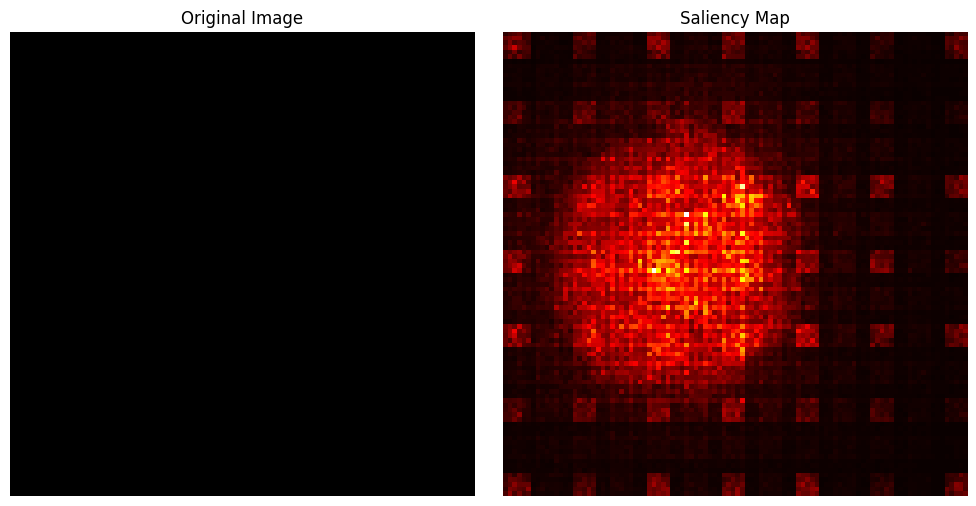

In [54]:
visualize_single_image_saliency(single_image, saliency_map)

In [77]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling3D, Conv3D

# Function to compute the saliency map
def compute_saliency_map_single(model, input_image, target_class_index):
    input_tensor = tf.convert_to_tensor(input_image, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        predictions = model(input_tensor)
        loss = predictions[:, target_class_index]

    # Compute gradients of the loss with respect to the input
    gradients = tape.gradient(loss, input_tensor)

    # Compute the absolute value of the gradients and take the maximum across the channel dimension
    saliency_map = np.max(np.abs(gradients), axis=-1)[0]
    return saliency_map

# Function to find the last convolutional layer
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, Conv3D):
            return layer
    return None

# Visualize the original image and its saliency map
def visualize_image_and_saliency(original_image, saliency_map,image_name, slice_index=50):
    plt.figure(figsize=(15, 5))
    
    # Original image (single slice)
    plt.subplot(1, 2, 1)
    plt.imshow(np.squeeze(original_image[0, :, :, slice_index, 0]), cmap='gray')
    plt.title(f"{image_name} (Slice {slice_index})")
    plt.axis('off')

    # Saliency map (single slice)
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(saliency_map[:, :, slice_index]), cmap='hot')
    plt.title(f"Saliency Map (Slice {slice_index})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    
    plt.savefig(f"{image_name} -- saliency map", dpi=300)
    plt.close()


Last convolutional layer: conv3d_15


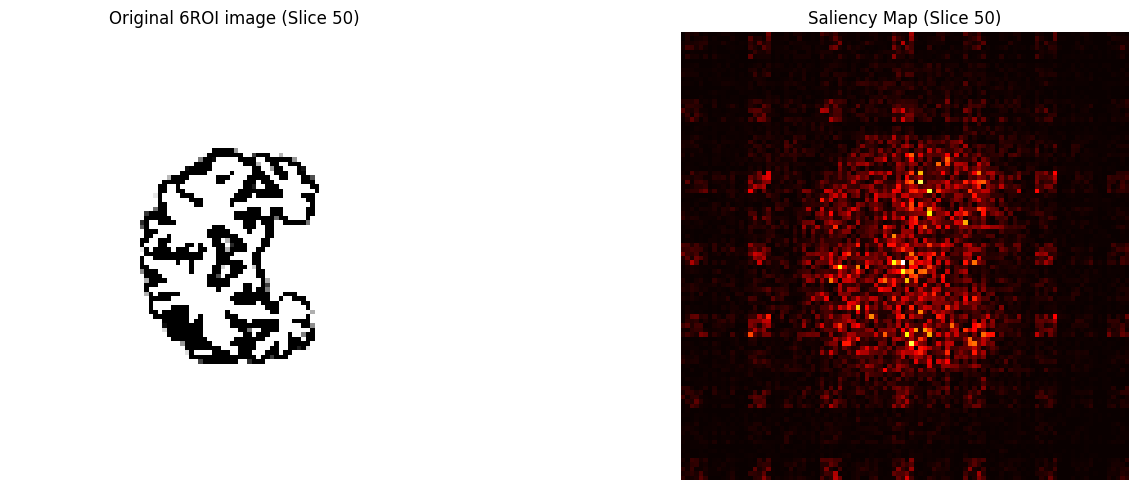

Predicted class: 1
True class: 1


In [78]:
# Get the last convolutional layer
last_conv_layer = find_last_conv_layer(model)
if last_conv_layer is None:
    raise ValueError("No convolutional layer found in the model.")

print(f"Last convolutional layer: {last_conv_layer.name}")

# Get a batch of test data
test_batch = next(iter(test_dataset))
test_images, test_labels = test_batch

# Select a single image and its label
single_image = test_images[0:1]  # Shape: (1, 100, 100, 100, 1)
single_label = test_labels[0]    # Shape: (2,) - one-hot encoded

# Convert one-hot encoded label to class index
target_class_index = int(np.argmax(single_label))

# Compute the saliency map
saliency_map = compute_saliency_map_single(model, single_image, target_class_index)

# Visualize the original image and saliency map
visualize_image_and_saliency(single_image, saliency_map, "Original 6ROI image")

# Print the predicted and true class
predictions = model.predict(single_image)
print(f"Predicted class: {np.argmax(predictions[0])}")
print(f"True class: {np.argmax(single_label)}")

In [55]:
model2 = tf.keras.models.load_model('../models/CBAM_UpgradedFilter_CompleteReg_IJK_ADNI_ADvsCN_v2.h5', compile=False)

2024-12-25 14:09:30.297500: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 131072000 exceeds 10% of free system memory.
2024-12-25 14:09:30.492807: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 262144000 exceeds 10% of free system memory.


In [79]:
last_conv_layer = find_last_conv_layer(model2)
if last_conv_layer is None:
    raise ValueError("No convolutional layer found in the model.")

print(f"Last convolutional layer: {last_conv_layer.name}")

# Get a batch of test data
test_batch = next(iter(test_full_dataset))
test_images, test_labels = test_batch

# Select a single image and its label
single_image = test_images[0:1]  # Shape: (1, 100, 100, 100, 1)
single_label = test_labels[0]    # Shape: (2,) - one-hot encoded

# Convert one-hot encoded label to class index
target_class_index = int(np.argmax(single_label))

# Compute the saliency map
saliency_map = compute_saliency_map_single(model2, single_image, target_class_index)

Last convolutional layer: conv3d_15


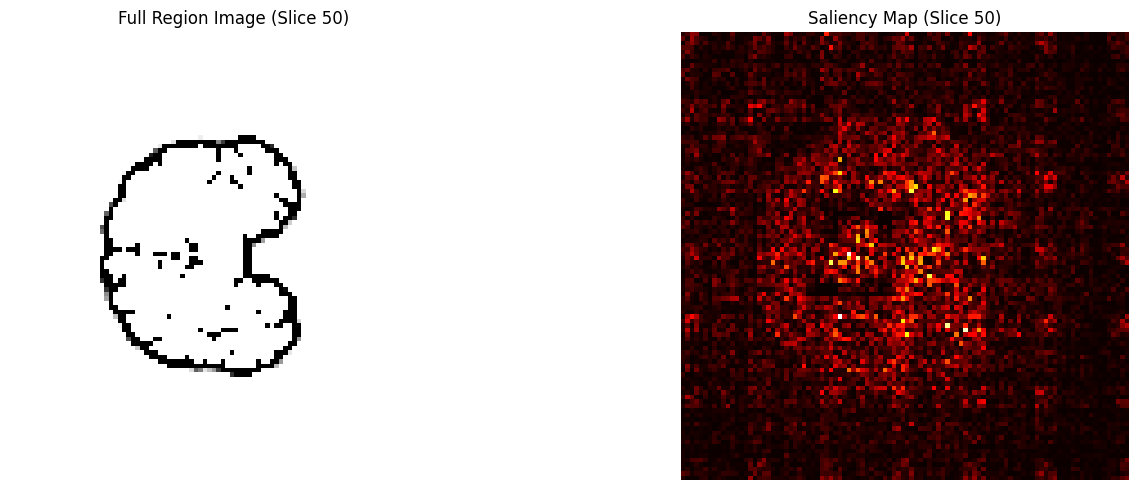

Predicted class: 1
True class: 1


In [80]:
# Visualize the original image and saliency map
visualize_image_and_saliency(single_image, saliency_map, "Full Region Image")

# Print the predicted and true class
predictions = model.predict(single_image)
print(f"Predicted class: {np.argmax(predictions[0])}")
print(f"True class: {np.argmax(single_label)}")